In [1]:
# Import some things
import os,sys,cv2
from __future__ import print_function

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# Bring in Xilinx ML Suite Compiler, Quantizer, PyXDNN
from xfdnn.tools.compile.bin.xfdnn_compiler_tensorflow import TFFrontend as xfdnnCompiler
from xfdnn.tools.quantize.quantize_tf import tf_Quantizer as xfdnnQuantizer
import xfdnn.rt.xdnn as xdnn
import xfdnn.rt.xdnn_io as xdnn_io
import time
import ipywidgets

import warnings
import time
import gc
import pandas as pd
warnings.simplefilter("ignore", UserWarning)

print("Current working directory: %s" % os.getcwd())
print("Running on host: %s" % os.uname()[1])
print("Running w/ LD_LIBRARY_PATH: %s" %  os.environ["LD_LIBRARY_PATH"])
print("Running w/ XILINX_OPENCL: %s" %  os.environ["XILINX_OPENCL"])
print("Running w/ XCLBIN_PATH: %s" %  os.environ["XCLBIN_PATH"])
print("Running w/ PYTHONPATH: %s" %  os.environ["PYTHONPATH"])
print("Running w/ SDACCEL_INI_PATH: %s" %  os.environ["SDACCEL_INI_PATH"])

id = !whoami

# Make sure there is no error in this cell
# The xfDNN runtime depends upon the above environment variables


Current working directory: /home/centos/ml-suite/notebooks
Running on host: ip-172-31-82-102.ec2.internal
Running w/ LD_LIBRARY_PATH: /opt/xilinx/xrt/lib::/home/centos/ml-suite/ext/boost/lib:/home/centos/ml-suite/ext/zmq/libs:/home/centos/ml-suite/overlaybins/aws/runtime/lib/x86_64
Running w/ XILINX_OPENCL: /home/centos/ml-suite/overlaybins/aws
Running w/ XCLBIN_PATH: /home/centos/ml-suite/overlaybins/aws
Running w/ PYTHONPATH: /home/centos/ml-suite:/home/centos/ml-suite/xfdnn/rt:/home/centos/ml-suite/ext:/home/centos/ml-suite/models/darknet/tools:/home/centos/ml-suite/apps/yolo:/home/centos/ml-suite/apps/yolo/nms:/home/centos/ml-suite/xfdnn/tools/emu:/home/centos/ml-suite/xfdnn/tools/compile/network:/home/centos/ml-suite/xfdnn/tools/compile/graph:/home/centos/ml-suite/xfdnn/tools/compile/optimizations:/home/centos/ml-suite/xfdnn/tools/compile/codegeneration:/home/centos/ml-suite/xfdnn/tools/compile/memory:/home/centos/ml-suite/xfdnn/tools/compile/version:/home/centos/ml-suite/xfdnn/to

In [2]:
def initializeFpgaModel(sProtoBufPath):
    config = {} # Config dict
    config["platform"] = 'aws'
    
    sInputNode,sOutputNode = getModelInputOutputNode(sProtoBufPath)
    # Compiler Arguments
    config["model"] = "GoogLeNet"
    #config["protobuf"] = "/home/centos/models/tensorflow/inception/frozen_inception_v3.pb"
    config["protobuf"] = sProtoBufPath
    #config["outmodel"] = "work/optimized_model" # String for naming optimized model NOT YET SUPPORTED
    config["netcfg"] = "work/fpga.cmds" # Compiler will generate FPGA instructions
    config["memory"] = 5 # Available on-chip SRAM
    config["dsp"] = 56 # Width of Systolic Array
    config["finalnode"] = sOutputNode # Terminal node in your tensorflow graph
    #config["finalnode"] = "prob" # Terminal node in your tensorflow graph

    compiler = xfdnnCompiler(
        networkfile=config["protobuf"],      # Protobuf filename: input file
        #anew=config["outmodel"],            # String for intermediate protobuf NOT YET SUPPORTED
        generatefile=config["netcfg"],       # Script filename: output file
        memory=config["memory"],             # Available on chip SRAM within xclbin
        dsp=config["dsp"],                   # Rows in DSP systolic array within xclbin # keep defaults 
        finalnode=config["finalnode"],       # Terminal node in your tensorflow graph
        weights=True                         # Instruct Compiler to generate a weights directory for runtime
    )

    # Invoke compiler
    try:
        compiler.compile()

        # The compiler extracts the floating point weights from the .caffemodel. 
        # This weights dir will be stored in the work dir with the appendex '_data'. 
        # The compiler will name it after the caffemodel, and append _data
        config["datadir"] = "work/" + os.path.basename(config["protobuf"]) + "_data"

        if os.path.exists(config["datadir"]) and os.path.exists(config["netcfg"]+".json"):
            print("Compiler successfully generated JSON and the data directory: {:s}".format(config["datadir"]))
        else:
            print("Compiler failed to generate the JSON or data directory: {:s}".format(config["datadir"]))
            raise

        print("**********\nCompilation Successful!\n")

        import json
        data = json.loads(open(config["netcfg"]+".json").read())
        print("Network Operations Count: {:d}".format(data['ops']))
        print("DDR Transfers (bytes): {:d}".format(data['moveops']))

    except Exception as e:
        print("Failed to complete compilation:",e)

    # Quantizing
    config["img_mean"] = [104.007, 116.669, 122.679] # Mean of the training set
    config["quantizecfg"] = "work/quantization_params.json" # Quantizer will generate quantization params
    config["calibration_directory"] = "../xfdnn/tools/quantize/calibration_directory" # Directory of images for quantizer
    config["calibration_size"] = 15 # Number of calibration images quantizer will use
    config["bitwidths"] = [16,16,16] # Supported quantization precision
    config["img_raw_scale"] = 255.0 # Raw scale of input pixels, i.e. 0 <-> 255
    config["img_input_scale"] = 1.0 # Input multiplier, Images are scaled by this factor after mean subtraction


    quantizer = xfdnnQuantizer(
        model_file=config["protobuf"],          # Prototxt filename: input file
        quantize_config=config["quantizecfg"],  # Quant filename: output file
        bitwidths=config["bitwidths"],          # Fixed Point precision: 8b or 16b
        cal_size=config["calibration_size"],    # Number of calibration images to use
        img_mean=config["img_mean"],            # Image mean per channel to caffe transformer
        cal_dir=config["calibration_directory"] # Directory containing calbration images
    )

    # Invoke quantizer
    try:
        quantizer.quantize(inputName = sInputNode, outputName = sOutputNode)

        import json
        data = json.loads(open(config["quantizecfg"]).read())
        print("**********\nSuccessfully produced quantization JSON file for %d layers.\n"%len(data['network']))
    except Exception as e:
        print("Failed to quantize:",e)

    # Create a handle with which to communicate to the FPGA
    # The actual handle is managed by xdnn
    config["xclbin"] = "../overlaybins/" + config["platform"] + "/overlay_3.xclbin" # Chosen Hardware Overlay
    ## NOTE: If you change the xclbin, we likely need to change some arguments provided to the compiler
    ## Specifically, the DSP array width, and the memory arguments

    ret, handles = xdnn.createHandle(config['xclbin'])

    if ret:                                                             
        print("ERROR: Unable to create handle to FPGA")
    else:
        print("INFO: Successfully created handle to FPGA")

    # If this step fails, most likely the FPGA is locked by another user, or there is some setup problem with the hardware
    return config,handles

In [3]:
def getModelInputOutputNode(sProtobufPath):
    import tensorflow as tf
    from tensorflow.python.platform import gfile
    with tf.Session() as sess:
        with gfile.FastGFile(sProtobufPath,'rb') as f:
            graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        sess.graph.as_default()
        tf.import_graph_def(graph_def, name='')
        graph_nodes=[n for n in graph_def.node]

        return graph_nodes[0].name, graph_nodes[len(graph_nodes)-1].name


In [4]:
# # Chose an image to run, display it for reference
# config["images"] = ["../examples/classification/dog.jpg","../examples/classification/dog.jpg"] # Image of interest (Must provide as a list)

# img = cv2.imread(config["images"][0])
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# plt.imshow(img)
# plt.title(config["images"])
# plt.show()

In [5]:
# Quantize, and transfer the weights to FPGA DDR
def TransferWeightsFPGA(iBatchSize,config,handles):
    # config["datadir"] = "work/" + config["caffemodel"].split("/")[-1]+"_data" # From Compiler
    config["scaleA"] = 10000 # Global scaler for weights (Must be defined)
    config["scaleB"] = 30 # Global scaler for bias (Must be defined)
    config["PE"] = 0 # Run on Processing Element 0 - Different xclbins have a different number of Elements
    config["batch_sz"] = iBatchSize # We will load 1 image at a time from disk
    config["in_shape"] = (3,224,224) # We will resize images to 224x224

    #(weightsBlob, fcWeight, fcBias ) = pyxfdnn_io.loadWeights(config)
    fpgaRT = xdnn.XDNNFPGAOp(handles,config)
    (fcWeight, fcBias) = xdnn_io.loadFCWeightsBias(config)
    return fpgaRT,fcWeight,fcBias,config

### Step 7. Allocate space in host memory for inputs, load images from disk, and prepare images. 

In [6]:
# Allocate space in host memory for inputs, Load images from disk
def AllocateMemoryToHost(config):
#     batch_array = np.empty(((config['batch_sz'],) + config['in_shape']), dtype=np.float32, order='C')
#     img_paths = xdnn_io.getFilePaths(config['images'])

#     for i in xrange(0, len(img_paths), config['batch_sz']):
#         pl = []
#         for j, p in enumerate(img_paths[i:i + config['batch_sz']]):
#             batch_array[j, ...], _ = xdnn_io.loadImageBlobFromFile(p, config['img_raw_scale'], config['img_mean'], 
#                                                                       config['img_input_scale'], config['in_shape'][2], 
#                                                                       config['in_shape'][1])
#             pl.append(p)
    # Allocate space in host memory for outputs
    if config["model"] == "GoogLeNet":
        config["fpgaoutsz"] = 1024 # Number of elements in the activation of the last layer ran on the FPGA
    elif config["model"] == "ResNet50":
        config["fpgaoutsz"] = 2048 # Number of elements in the activation of the last layer ran on the FPGA

    config["outsz"] = 1000 # Number of elements output by FC layers (1000 used for imagenet)

    fpgaOutput = np.empty ((config['batch_sz'], config['fpgaoutsz'],), dtype=np.float32, order='C') # Space for fpga output
    fcOutput = np.empty((config['batch_sz'], config['outsz'],), dtype=np.float32, order='C') # Space for output of inner product
   
    return fpgaOutput, fcOutput,config

In [7]:
def generateRandomBatch(iBatchSize,config):
    return np.random.rand(iBatchSize,3,224,224).astype(np.float32)

### Step 12. Output the classification prediction scores.

In [8]:
# # Print the classification given the labels synset_words.txt (Imagenet classes)
# config["labels"] = "../examples/classification/synset_words.txt"
# labels = xdnn_io.get_labels(config['labels'])
# xdnn_io.printClassification(softmaxOut, pl, labels)

# #Print Original Image for Reference 
# img = cv2.imread(config["images"][0])
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# plt.imshow(img)
# plt.title(config["images"])
# plt.show()

In [9]:
def runOnFPGA(iBatchSize,config,handle,batchArray):
    # Load weights to FPGA
    fpgaRT,fcWeight,fcBias,config=TransferWeightsFPGA(iBatchSize,config,handle)
    
    #Allocate Memory to host
    fpgaOutput, fcOutput,config=AllocateMemoryToHost(config)
    
    #Generate Image batches to run
#     batch_array= generateRandomBatch(iBatchSize,config)
    
    # Write FPGA Instructions to FPGA and Execute the network!
    start = time.time()
    fpgaRT.execute(batch_array, fpgaOutput)
    
    # Compute the inner product
    xdnn.computeFC(fcWeight, fcBias, fpgaOutput, config['batch_sz'], config['outsz'], config['fpgaoutsz'], fcOutput)
    
    # Compute the softmax to convert the output to a vector of probabilities
    softmaxOut = xdnn.computeSoftmax(fcOutput)
    
    #Return the output
    return softmaxOut, time.time()-start    

In [10]:
#Provide the Model checkpoint path

sProtoBufPath="/home/centos/models/tensorflow/bvlc_googlenet_without_lrn/fp32/bvlc_googlenet_without_lrn_test.pb"

#Intantiate the FPGA configuration
config,handle=initializeFpgaModel(sProtoBufPath)

Inference_Data =[]
#Get Image batch to start inference
for i in range(0,7):
    
    iBatchSize = 2**i
    
    #Generate batch 10 * batchsize
    batch_array=generateRandomBatch(1*iBatchSize,config)
    
    print("starting prediction for batchsize : {} over {} images".format(iBatchSize,len(batch_array)))
    
    start = time.time()
    
    #Run prdeiction on FPGA
    out,actualTime = runOnFPGA(iBatchSize,config,handle,batch_array)
   
    end = time.time()
    
    duration = end-start
    
    Inference_Data.append({"duration":duration, "duration_actual_run":actualTime
                                         ,"imgsPerSec": len(batch_array)/duration,"batchSize":iBatchSize,
                                          "imgsPerSecAc": len(batch_array)/actualTime})
    del batch_array,out
    gc.collect()

    #Close the fpga handle 
xdnn.closeHandle()



Namespace(anew=None, approximate=False, banditpre=None, barrier=False, bridges=None, bytesperpixels=2, concatstrategy=None, conv_1x1_s2=False, cpulayermustgo=False, ddr=256, dedicateddsp=None, deephifilename=None, dsp=56, finalnode=u'prob', forceweights=None, fromtensorflow=False, generatefile='work/fpga.cmds', godreplication=None, lasttensorbyname=None, loadpickle=None, manasadebugmode=False, manualbatch=False, manualdeconv=False, memory=5, networkfile='/home/centos/models/tensorflow/bvlc_googlenet_without_lrn/fp32/bvlc_googlenet_without_lrn_test.pb', nodynamicscaling=False, noreplication=False, parallelism=False, parallelismstrategy="['bottom', 'tops']", parallelread=None, pipelineconvmaxpool=False, placeholdershape=None, pngfile=None, poolingaround=False, rankdir='BT', savepickle=None, schedulefile=None, strategy='all', verbose=False, versionjson=None, weights=True)
Network: /home/centos/models/tensorflow/bvlc_googlenet_without_lrn/fp32/bvlc_googlenet_without_lrn_test.pb
GenerateCod

Minimum Memory __________
17 [u'inception_3b_3x3/Conv2D'] size:3440640.0 remap:[] data movement:[]
17	inception_3b_3x3_reduce/Conv2D_blob M[0,458752] Z=458752 F=[17] B=[16] E=[] S=['layer'] [] L=-1 T=SizeType(batches=1, channels=128, height=28, width=28)
17	inception_3a_output_blob M[0,917504] Z=917504 F=[14, 15, 16, 18] B=[13] E=[] S=['replace_layer'] ['concat'] L=-1 T=SizeType(batches=1, channels=256, height=28, width=28)
17	inception_3b_pool_blob M[0,917504] Z=917504 F=[20] B=[14] E=[] S=['layer'] [] L=-1 T=SizeType(batches=1, channels=256, height=28, width=28)
17	inception_3b_1x1/Conv2D_blob M[0,458752] Z=458752 F=[21] B=[15] E=[] S=['layer'] ['concat'] L=-1 T=SizeType(batches=1, channels=128, height=28, width=28)
17	inception_3b_3x3/Conv2D_blob M[0,688128] Z=688128 F=[21] B=[17] E=[] S=['layer'] ['concat'] L=-1 T=SizeType(batches=1, channels=192, height=28, width=28)
MAX  17
TOP 5
__________
17 [u'inception_3b_3x3/Conv2D'] size:3440640.0 remap:[] data movement:[]
17	inception_3b_3

Compiling weights from: /home/centos/models/tensorflow/bvlc_googlenet_without_lrn/fp32/bvlc_googlenet_without_lrn_test.pb

**************************************************
* CLEANING PREVIOUS WEIGHTS:work/bvlc_googlenet_without_lrn_test.pb_data
* wbq_size_0
* fwbqb_0
* fwbqb_bias_0
* wbq_size_1
* fwbqb_1
* fwbqb_bias_1
* wbq_size_2
* fwbqb_2
* fwbqb_bias_2
* wbq_size_3
* fwbqb_3
* fwbqb_bias_3
* wbq_size_4
* fwbqb_4
* fwbqb_bias_4
* wbq_size_5
* fwbqb_5
* fwbqb_bias_5
* wbq_size_6
* fwbqb_6
* fwbqb_bias_6
* wbq_size_7
* fwbqb_7
* fwbqb_bias_7
* wbq_size_8
* fwbqb_8
* fwbqb_bias_8
* wbq_size_9
* fwbqb_9
* fwbqb_bias_9
* wbq_size_10
* fwbqb_10
* fwbqb_bias_10
* wbq_size_11
* fwbqb_11
* fwbqb_bias_11
* wbq_size_12
* fwbqb_12
* fwbqb_bias_12
* wbq_size_13
* fwbqb_13
* fwbqb_bias_13
* wbq_size_14
* fwbqb_14
* fwbqb_bias_14
* wbq_size_15
* fwbqb_15
* fwbqb_bias_15
* wbq_size_16
* fwbqb_16
* fwbqb_bias_16
* wbq_size_17
* fwbqb_17
* fwbqb_bias_17
* wbq_size_18
* fwbqb_18
* fwbqb_bias_18
* wb

Classifying
('Min: ', 0, ', Max: ', 150.993)
('n: ', 32768, ', len(bin_edges): ', 1504)
('Mean : th_layer_out: ', 150.9929962158203, ', sf_layer_out: ', 0.00460808118582172)
('Min: ', 0, ', Max: ', 1774.9265)
('Min: ', 0, ', Max: ', 5280.0757)
('Min: ', 0, ', Max: ', 1999.3662)
('Min: ', 0, ', Max: ', 5696.549)
('Min: ', 0, ', Max: ', 2007.4005)
('n: ', 32768, ', len(bin_edges): ', 615)
('Mean : th_layer_out: ', 5696.548828125, ', sf_layer_out: ', 0.1738501793916135)
('Min: ', 0, ', Max: ', 2934.8054)
('Min: ', 0, ', Max: ', 3054.7993)
('Min: ', 0, ', Max: ', 2570.7114)
('Min: ', 0, ', Max: ', 4279.9414)
('n: ', 32768, ', len(bin_edges): ', 869)
('Mean : th_layer_out: ', 2934.805419921875, ', sf_layer_out: ', 0.08956588701809366)
('Min: ', 0, ', Max: ', 3253.8406)
('n: ', 32768, ', len(bin_edges): ', 1737)
('Mean : th_layer_out: ', 1774.926513671875, ', sf_layer_out: ', 0.05416811162669378)
('Min: ', 0, ', Max: ', 2232.0608)
('n: ', 32768, ', len(bin_edges): ', 1228)
('Mean : th_layer_

('n: ', 32768, ', len(bin_edges): ', 1228)
('Mean : th_layer_out: ', 1138.6231689453125, ', sf_layer_out: ', 0.03474908197104747)
('n: ', 32768, ', len(bin_edges): ', 652)
('Mean : th_layer_out: ', 298.6078186035156, ', sf_layer_out: ', 0.009113065541658243)
('n: ', 32768, ', len(bin_edges): ', 652)
('Mean : th_layer_out: ', 298.23724365234375, ', sf_layer_out: ', 0.009101756146499336)
('Min: ', 0, ', Max: ', 348.25443)
('n: ', 32768, ', len(bin_edges): ', 1228)
('Mean : th_layer_out: ', 429.3624572753906, ', sf_layer_out: ', 0.013103502220996448)
('Min: ', 0, ', Max: ', 98.86968)
('n: ', 32768, ', len(bin_edges): ', 308)
('Mean : th_layer_out: ', 348.2544250488281, ', sf_layer_out: ', 0.010628205970910616)
('Min: ', 0, ', Max: ', 429.36246)
('Min: ', 0, ', Max: ', 429.36246)
('Min: ', 0, ', Max: ', 429.36246)
('n: ', 32768, ', len(bin_edges): ', 1228)
('Mean : th_layer_out: ', 671.99169921875, ', sf_layer_out: ', 0.020508185040398877)
('Min: ', 0, ', Max: ', 348.26794)
('n: ', 32768, 

('n: ', 32768, ', len(bin_edges): ', 1737)
('Mean : th_layer_out: ', 2239.405029296875, ', sf_layer_out: ', 0.06834330360719244)
('n: ', 32768, ', len(bin_edges): ', 2377)
('Mean : th_layer_out: ', 1179.1551513671875, ', sf_layer_out: ', 0.035986057660670416)
Writing output files to work/quantization_params.json...
**********
Successfully produced quantization JSON file for 57 layers.

INFO: Successfully created handle to FPGA
starting prediction for batchsize : 1 over 1 images
Loading weights/bias/quant_params to FPGA...
starting prediction for batchsize : 2 over 2 images
Loading weights/bias/quant_params to FPGA...
starting prediction for batchsize : 4 over 4 images
Loading weights/bias/quant_params to FPGA...
starting prediction for batchsize : 8 over 8 images
Loading weights/bias/quant_params to FPGA...
starting prediction for batchsize : 16 over 16 images
Loading weights/bias/quant_params to FPGA...
starting prediction for batchsize : 32 over 32 images
Loading weights/bias/quant_p

In [11]:
#Print inference data and plot
Inference_Data = pd.DataFrame(Inference_Data)
Inference_Data

,batchSize,duration,duration_actual_run,imgsPerSec,imgsPerSecAc
0,1,2.907825,0.007808,0.343900,128.074262
1,2,2.764549,0.009607,0.723445,208.185040
2,4,2.779084,0.017047,1.439323,234.646378
3,8,2.796970,0.031426,2.860238,254.566664
4,16,2.843636,0.060329,5.626600,265.212593
5,32,2.911557,0.118503,10.990683,270.035144
6,64,3.035080,0.234035,21.086759,273.463353


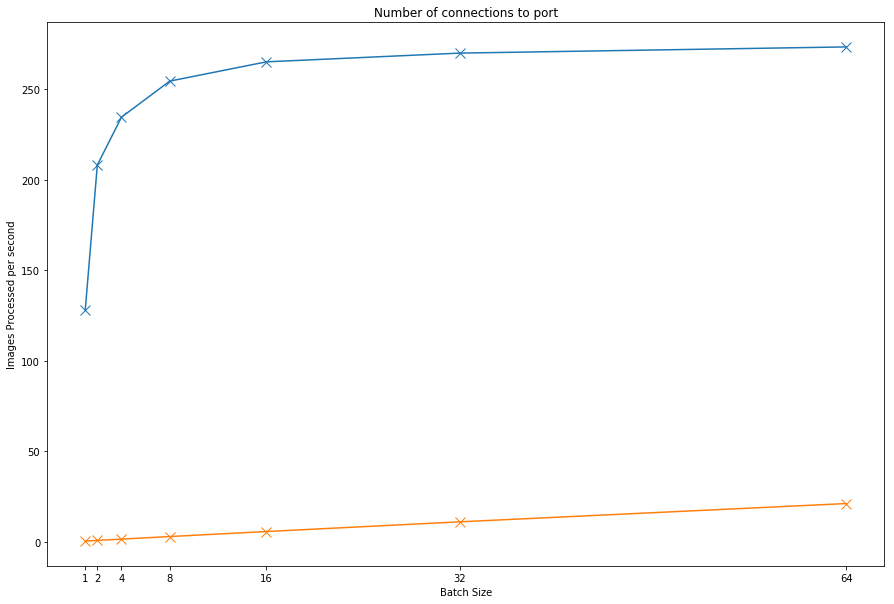

In [12]:
import matplotlib.path as mpath
f, ax = plt.subplots(figsize=(15, 10))
plt.title('Number of connections to port')
ax.set_xlabel("Batch Size")
plt.ylabel('Images Processed per second')
plt.xticks(Inference_Data['batchSize'], Inference_Data['batchSize'])
#plot images processed without initializing host memory ports- done on changing batch size
ax.plot(Inference_Data['batchSize'],Inference_Data['imgsPerSecAc'],marker='x', markersize=10)
#plot images processed with initializing host memory ports
ax.plot(Inference_Data['batchSize'],Inference_Data['imgsPerSec'],marker='x', markersize=10)